In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [82]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": [
        "Hi",
        "Hey",
        "How are you",
        "Is anyone there?",
        "Hello",
        "Good day"
      ],
      "responses": [
        "Hey :-)",
        "Hello, thanks for visiting",
        "Hi there, what can I do for you?",
        "Hi there, how can I help?"
      ]
    },
    {
      "tag": "goodbye",
      "input": ["Bye", "See you later", "Goodbye"],
      "responses": [
        "See you later, thanks for visiting",
        "Have a nice day",
        "Bye! Come back again soon."
      ]
    },
    {
      "tag": "thanks",
      "input": ["Thanks", "Thank you", "That's helpful", "Thank's a lot!"],
      "responses": ["Happy to help!", "Any time!", "My pleasure"]
    },
    {
      "tag": "items",
      "input": [
        "Which items do you have?",
        "What kinds of items are there?",
        "What do you sell?",
        "menu please","menu"
      ],
                     
       "responses":["Our menu options include: Chicken Buckets: Classic, Spicy,Popcorn, Hot Wings,Burgers: Zinger, Tower, BBQ Bacon. Wraps: Twister, Boxmaster. Sides: Fries, Coleslaw, Biscuits. Drinks: Iced tea, Lemonade. What would you like to order?"]
        
        
    },
    {
      "tag":"classic chicken bucket",
      "input":["what is the price for classic chicken buckets?","one classic chicken bucket","classic chicken bucket","classic","how much for clssic chicken bucket?","cost of classic chicken bucket?"
          
    ],
    "responses":["8.99$","classic chicken bucket cost $8.99"]
        
        
    },
    {
      "tag":"spicy chicken bucket",
      "input":["what is the price for spicy chicken buckets?","one spicy chicken bucket","spicy chicken bucket","spicy","how much for spicy chicken bucket?","cost of spicy chicken bucket?"],
      "responses":["The price for one Spicy Chicken Bucket is 9.99$."]
    },
    {
      "tag":"popcorn chicken bucket",
      "input":["what is the price for popcorn chicken buckets?","one popcorn chicken bucket","popcorn chicken bucket","popcorn","how much for popcorn chicken bucket?","cost of popcorn chicken bucket?"],
      "responses":["The price for one Popcorn Chicken Bucket is 7.99$."]
    },
    {
      "tag":"hot wings bucket",
      "input":["what is the price for hot wings buckets?","one hot wings bucket","hot wings bucket","hot wings","how much for hot wings bucket?","cost of hot wings bucket?"],
      "responses":["The price for one Hot Wings Bucket is 10.99$."]
    }, 
      
    {
      "tag": "zinger_burger",
      "input": [
        "Tell me about the Zinger Burger",
        "What is the Zinger Burger",
        "Can you describe the Zinger Burger",
        "I want to try the Zinger Burger"
      ],
      "responses": [
        "The Zinger Burger is a spicy chicken fillet served with lettuce and mayo, all on a sesame seed bun. Would you like to order one?",
        "The Zinger Burger is a customer favorite! It's a spicy chicken sandwich with a crispy fillet, lettuce, and mayo. Would you like to try one?",
        "The Zinger Burger is one of our most popular items. It's a spicy chicken sandwich with a crispy fillet, lettuce, and mayo, all on a sesame seed bun. Would you like to order one?"
      ]
    },
    {
      "tag": "zinger_burger_price",
      "input": [
        "How much does the Zinger Burger cost?",
        "What is the price of the Zinger Burger?",
        "Can you tell me the cost of the Zinger Burger?"
     ],
      "responses": [
        "The Zinger Burger costs $5.99",
        "The price of the Zinger Burger is $5.99",
        "The Zinger Burger is $5.99"
      ]
    },
    {
    "tag":"tower burger",
    "input":["what is the price of the tower burger?","tower burger","one tower burger","cost of tower burger"],
    "responses":[ "The tower Burger costs $6.99",
        "The price of the tower Burger is $6.99",
        "The tower Burger is $6.99"]
    },
    {
        "tag":"bbq bacon",
        "input":["what is the price of the bbq bacon?","bbq bacon","one bbq bacon","cost of bbq bacon"],
        "responses":["The bbq bacon costs $9",
        "The price of the  bbq bacon is $9",
        "The bbq bacon is $9"]
    },
    {
       "tag":"wraps",
        "input":["What is the variety of wraps that are available?",
                  "Could you tell me how many different types of wraps there are?",
                   "Are there any other kinds of wraps available?",
                   "I'm curious about the number of wrap varieties that are available. Can you tell me?","wraps"],
        "responses":["we have two types of wraps,Twister, Boxmaster"]
        
    },
    {
        "tag":"twister price",
        "input":["what is the price of the twister?","twister","one twister","cost of twister"],
        "responses":["The twister costs $4",
        "The price of the twister bacon is $4",
        "The twister is $4"]
    },
    {
        "tag":"boxmaster price",
        "input":["what is the price of the boxmaster?","boxmaster","one boxmaster","boxmaster please","cost of boxmaster"],
        "responses":["The boxmaster costs $8",
        "The price of the boxmaster bacon is $8",
        "The boxmaster is $8"]
        
    },
    {
       "tag":"sides",
        "input":["What is the variety of sides that are available?",
                  "Could you tell me how many different types of sides there are?",
                   "Are there any other kinds of sides available?",
                   "I'm curious about the number of sides varieties that are available. Can you tell me?","sides?","sides"],
        "responses":["we have Fries and Coleslaw"]
        
    },
    {
        "tag":"fries price",  
        "input":["what is the price of the fries?","fries","one fries","fries please","cost of fries"],
        "responses":["The fries costs $5",
        "The price of the fries is $5",
        "The fries is $5"]
        
    },
    {
        "tag":"Coleslaw price", 
        "input":["what is the price of the Coleslaw?","one Coleslaw","Coleslaw please","cost of Coleslaw","Coleslaw"],
        "responses":["The Coleslaw costs $5"]
    },
    {
       "tag":"BiscuitsDrinks",
        "input":[
            "What is the variety of BiscuitsDrinks that are available?",
                  "Could you tell me how many different types of BiscuitsDrinks there are?",
                   "Are there any other kinds of BiscuitsDrinks available?",
                   "I'm curious about the number of BiscuitsDrinks varieties that are available. Can you tell me?","BiscuitsDrinks?","BiscuitsDrinks"
        ],
        "responses":[
            "we have Iced tea,Lemonade"
                    ]
        
    },
     {
        "tag":"Iced tea", 
        "input":[
            "what is the price of the Iced tea?","one Iced tea","Iced tea please","cost of Iced tea","Iced tea"
         ],
        "responses":[
            "The Iced tea costs $10"
        ]
    },  
    {
        "tag":"Lemonade", 
        "input":["what is the price of the Lemonade?","one Lemonade","Lemonade please","cost of Lemonade","Lemonade"],
        "responses":["The Lemonade costs $11.54"]
    }, 
      
    {
      "tag": "payments",
      "input": [
        "Do you take credit cards?",
        "Do you accept Mastercard?",
        "Can I pay with Paypal?",
        "Are you cash only?"
      ],
      "responses": [
        "We accept VISA, Mastercard and Paypal",
        "We accept most major credit cards, and Paypal"
      ]
    },
    {
      "tag":"order",
      "input":[""]
        
        
    } 
      
      
      
      
    {
      "tag": "delivery",
      "input": [
        "How long does delivery take?",
        "How long does shipping take?",
        "When do I get my delivery?"
      ],
      "responses": [
        "Delivery takes 2-4 days",
        "Shipping takes 2-4 days"
      ]
    },
    {
      "tag": "funny",
      "input": [
        "Tell me a joke!",
        "Tell me something funny!",
        "Do you know a joke?"
      ],
      "responses": [
        "Why did the hipster burn his mouth? He drank the coffee before it was cool.",
        "What did the buffalo say when his son left for college? Bison."
      ]
    }
  ]
}

Overwriting content.json


In [83]:
#importing the dataset
with open('content.json') as content:
    data1=json.load(content)

In [84]:

tags=[]
inputs=[]
responses={}
for intent in data1['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])


In [85]:
data=pd.DataFrame({"inputs":inputs,"tags":tags})
data

,inputs,tags
0,Hi,greeting
1,Hey,greeting
2,How are you,greeting
3,Is anyone there?,greeting
4,Hello,greeting
...,...,...
107,How long does shipping take?,delivery
108,When do I get my delivery?,delivery
109,Tell me a joke!,funny
110,Tell me something funny!,funny


In [86]:
data=data.sample(frac=1)

In [87]:
#removing the punctuactions
import string
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
13,which items do you have,items
4,hello,greeting
56,what is the variety of wraps that are available,wraps
96,iced tea,Iced tea
57,could you tell me how many different types of ...,wraps
...,...,...
24,one spicy chicken bucket,spicy chicken bucket
67,one boxmaster,boxmaster price
26,spicy,spicy chicken bucket
40,cost of hot wings bucket,hot wings bucket


In [88]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

In [89]:
#tensorflow"s tokenizer assigns a unique token to each distinct word and padding is done to get all the data to the same length so as to send it to an rnn layer
input_shape=x_train.shape[1]
print(input_shape)

15


In [90]:
#define vocabulary
vocabulary=len(tokenizer.word_index)
print("number of unique words:",vocabulary)
output_length=le.classes_.shape[0]
print("output length:",output_length)

number of unique words: 105
output length: 24


# neural network

In [91]:
#creating the model
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

In [92]:
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [93]:
#training the model
train=model.fit(x_train,y_train,epochs=200)

Epoch 1/200
4/4 [==============================] - 14s 95ms/step - loss: 3.1793 - accuracy: 0.0536
Epoch 2/200
4/4 [==============================] - 0s 23ms/step - loss: 3.1760 - accuracy: 0.0536
Epoch 3/200
4/4 [==============================] - 0s 37ms/step - loss: 3.1737 - accuracy: 0.0982
Epoch 4/200
4/4 [==============================] - 0s 20ms/step - loss: 3.1713 - accuracy: 0.1161
Epoch 5/200
4/4 [==============================] - 0s 26ms/step - loss: 3.1691 - accuracy: 0.1250
Epoch 6/200
4/4 [==============================] - 0s 21ms/step - loss: 3.1664 - accuracy: 0.1607
Epoch 7/200
4/4 [==============================] - 0s 20ms/step - loss: 3.1638 - accuracy: 0.1786
Epoch 8/200
4/4 [==============================] - 0s 22ms/step - loss: 3.1606 - accuracy: 0.1518
Epoch 9/200
4/4 [==============================] - 0s 21ms/step - loss: 3.1571 - accuracy: 0.1786
Epoch 10/200
4/4 [==============================] - 0s 21ms/step - loss: 3.1530 - accuracy: 0.1518
Epoch 11/200
4/4 [

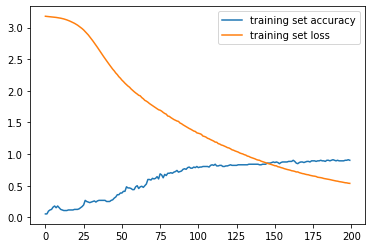

In [94]:
#plotting the model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [ ]:
#testing the model
import random
while True:
    texts_p=[]
    prediction_input=input('you:')
    
    #removing punctuation and converting to lowercase
    prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input=''.join(prediction_input)
    texts_p.append(prediction_input)
    
    #tokenizing and padding
    prediction_input=tokenizer.texts_to_sequences(texts_p)
    prediction_input=np.array(prediction_input).reshape(-1)
    prediction_input=pad_sequences([prediction_input],input_shape)
    
    #getting output from model
    output=model.predict(prediction_input)
    output=output.argmax()
    
    #finding the right tag and predicting
    response_tag=le.inverse_transform([output])[0]
    print("chickendaddy: ",random.choice(responses[response_tag]))
    if response_tag=="goodbye":
        break
    

you:zinger burger
1/1 [==============================] - 2s 2s/step
chickendaddy:  The Iced tea costs $10
you:BiscuitsDrinks
1/1 [==============================] - 0s 204ms/step
chickendaddy:  Hi there, what can I do for you?
you:boxmaster
1/1 [==============================] - 0s 86ms/step
chickendaddy:  The price of the boxmaster bacon is $8
you:wraps
1/1 [==============================] - 0s 205ms/step
chickendaddy:  The Lemonade costs $11.54
you:hot wings
1/1 [==============================] - 0s 153ms/step
chickendaddy:  The price for one Hot Wings Bucket is 10.99$.
you:menu
1/1 [==============================] - 0s 65ms/step
chickendaddy:  Hi there, what can I do for you?
you:menu
1/1 [==============================] - 0s 149ms/step
chickendaddy:  Hello, thanks for visiting
you:hi
1/1 [==============================] - 0s 57ms/step
chickendaddy:  Hey :-)
you:menu please
1/1 [==============================] - 0s 56ms/step
chickendaddy:  Our menu options include: Chicken Buckets: C